# Wasserstein GAN

Brief introduction to Wasserstein GAN or WGANs. This notebook is organized as follows:

1. **Research Paper**
2. **Background**
3. **Definition**
4. **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf)

## 2. Background

Brief definition of some concepts, such as Wasserstein distance.

### Wasserstein distance

The Wasserstein distance is the cost of the cheapest transport plan or the minimum cost of transporting mass in converting the data distribution $q$ to the data distribution $p$. 

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Wasserstein GAN (WGAN) proposes a new cost function using Wasserstein distance that has a smoother gradient everywhere. This model is proposed to measure the difference between the data distributions of real and generated images.

This network is very similar to the discriminator **$D$**, just without the sigmoid function and outputs a scalar score rather than a probability.

The discriminator **$D$** is rename to **Critic** to reflect its new role. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion

| Model | Discriminator/Critic | Generator             |
|:-----:|:--------------------:|:---------------------:|
| **GAN**   |  $$ \nabla_{\theta_{d}}\frac{1}{m}\sum_{i=1}^{m} [log(D(x^{(i)})) + log(1-D(G(z^{(i)})))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -log(D(G(z^{(i)})))$$|
| **WGAN**  |$$ \nabla_{w}\frac{1}{m}\sum_{i=1}^{m} [f(x^{(i)}) - f(G(z^{(i)}))]$$ | $$ \nabla_{\theta_{g}}\frac{1}{m}\sum_{i=1}^{m} -f(G(z^{(i)}))$$|

* **Wasserstein objective:**

```
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
```    
* **Critic training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(x^{(i)})$
* Minimize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$
* Weight clipping:

```
for l in critic.layers:
    weights = l.get_weights()
    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
    l.set_weights(weights)
```

* **Generator training:**

1. Maximize $\frac{1}{m}\sum_{i=1}^{m} f(G(z^{(i)}))$

## 3. Training WGANs with MNIST dataset,  Keras and TensorFlow

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * **No activation** in the last layer
    
* **Loss**
    * wasserstein_loss

* **Optimizer**
    * RMSprop(lr=0.00005)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-06 14:47:46.475485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 14:47:46.507344: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


#### Explore visual data

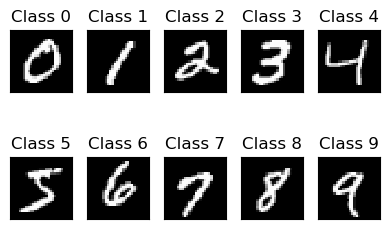

In [3]:
WIDTH_SIZE = 4
HEIGHT_SIZE = 3

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train.shape', X_train.shape)

if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)


X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator


In [5]:
latent_dim = 100

generator = tf.keras.Sequential()
generator.add(
    tf.keras.layers.Dense(
        7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(tf.keras.layers.Reshape((7, 7, 256)))

generator.add(
    tf.keras.layers.Conv2DTranspose(
        128, 5, strides=1, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        64, 5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        1, 5, strides=2, padding="same", use_bias=False, activation="tanh"
    )
)



2023-11-06 14:47:47.629503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:47:47.644008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:47:47.644128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:47:47.645084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [6]:
# prints a summary representation of your model
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

#### Critic


In [7]:
critic = tf.keras.Sequential()
critic.add(
    tf.keras.layers.Conv2D(
        64, 5, strides=2, padding="same", input_shape=[28, 28, 1]
    )
)
critic.add(tf.keras.layers.LeakyReLU())
critic.add(tf.keras.layers.Dropout(0.3))

critic.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding="same"))
critic.add(tf.keras.layers.LeakyReLU())
critic.add(tf.keras.layers.Dropout(0.3))

critic.add(tf.keras.layers.Flatten())
critic.add(tf.keras.layers.Dense(1))



#### Critic model visualization

In [8]:
# prints a summary representation of your model
critic.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

### 3. Compile model

#### Compile discriminator

In [9]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)


In [10]:
# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])


#### Combined network

We connect the generator and the critic to make a WGAN.

In [11]:
critic.trainable = False

# The generator takes noise as input and generated imgs
z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)

# The critic takes generated images as input and determines validity
valid = critic(img)

# The combined model (critic and generative)
c_g = tf.keras.models.Model(inputs=z, outputs=valid, name='wgan')

c_g.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])


#### GAN model vizualization

In [12]:
# prints a summary representation of your model
c_g.summary()


Model: "wgan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


### 4. Fit model


2023-11-06 14:47:48.162539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-11-06 14:47:48.167574: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-06 14:47:48.214453: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 14:47:48.214978: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 14:47:48.214994: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-06 14:47:48.215592: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 14:47:48.215652: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

epoch = 1/100, d_loss=-0.033, g_loss=-0.835                                                                                                                         


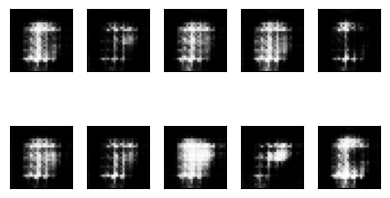

epoch = 2/100, d_loss=0.002, g_loss=-1.133                                                                                                                       
epoch = 3/100, d_loss=-0.027, g_loss=-0.570                                                                                                                      
epoch = 4/100, d_loss=-0.028, g_loss=-0.532                                                                                                                      
epoch = 5/100, d_loss=-0.040, g_loss=-0.506                                                                                                                      
epoch = 6/100, d_loss=-0.044, g_loss=-0.435                                                                                                                      
epoch = 7/100, d_loss=-0.069, g_loss=-0.404                                                                                                                      
epoch = 8/100, d_loss=-0.094

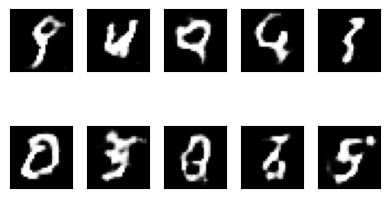

epoch = 12/100, d_loss=-0.086, g_loss=-0.122                                                                                                                      
epoch = 13/100, d_loss=-0.080, g_loss=-0.140                                                                                                                      
epoch = 14/100, d_loss=-0.085, g_loss=-0.127                                                                                                                      
epoch = 15/100, d_loss=-0.071, g_loss=-0.122                                                                                                                      
epoch = 16/100, d_loss=-0.073, g_loss=-0.096                                                                                                                      
epoch = 17/100, d_loss=-0.071, g_loss=-0.080                                                                                                                      
epoch = 18/100, d_loss

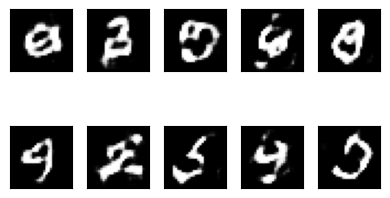

epoch = 22/100, d_loss=-0.090, g_loss=-0.114                                                                                                                      
epoch = 23/100, d_loss=-0.107, g_loss=-0.116                                                                                                                      
epoch = 24/100, d_loss=-0.101, g_loss=-0.127                                                                                                                      
epoch = 25/100, d_loss=-0.132, g_loss=-0.164                                                                                                                      
epoch = 26/100, d_loss=-0.152, g_loss=-0.172                                                                                                                      
epoch = 27/100, d_loss=-0.151, g_loss=-0.173                                                                                                                      
epoch = 28/100, d_loss

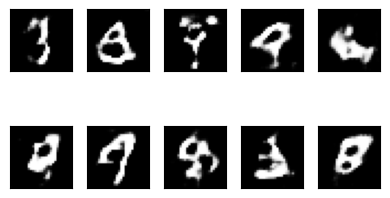

epoch = 32/100, d_loss=-0.111, g_loss=-0.106                                                                                                                      
epoch = 33/100, d_loss=-0.109, g_loss=-0.105                                                                                                                      
epoch = 34/100, d_loss=-0.094, g_loss=-0.113                                                                                                                      
epoch = 35/100, d_loss=-0.087, g_loss=-0.118                                                                                                                      
epoch = 36/100, d_loss=-0.088, g_loss=-0.119                                                                                                                      
epoch = 37/100, d_loss=-0.086, g_loss=-0.110                                                                                                                      
epoch = 38/100, d_loss

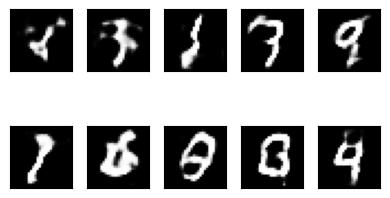

epoch = 42/100, d_loss=-0.053, g_loss=-0.152                                                                                                                      
epoch = 43/100, d_loss=-0.053, g_loss=-0.148                                                                                                                      
epoch = 44/100, d_loss=-0.047, g_loss=-0.121                                                                                                                      
epoch = 45/100, d_loss=-0.046, g_loss=-0.126                                                                                                                      
epoch = 46/100, d_loss=-0.043, g_loss=-0.127                                                                                                                      
epoch = 47/100, d_loss=-0.040, g_loss=-0.125                                                                                                                      
epoch = 48/100, d_loss

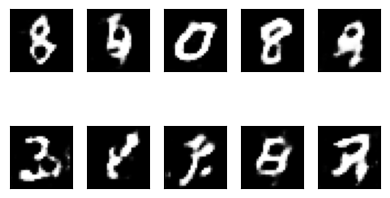

epoch = 52/100, d_loss=-0.038, g_loss=-0.056                                                                                                                      
epoch = 53/100, d_loss=-0.053, g_loss=-0.020                                                                                                                      
epoch = 54/100, d_loss=-0.034, g_loss=-0.022                                                                                                                      
epoch = 55/100, d_loss=-0.067, g_loss=-0.041                                                                                                                      
epoch = 56/100, d_loss=-0.060, g_loss=-0.081                                                                                                                      
epoch = 57/100, d_loss=-0.071, g_loss=-0.065                                                                                                                      
epoch = 58/100, d_loss

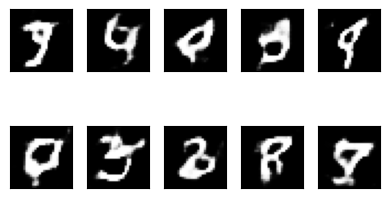

epoch = 62/100, d_loss=-0.048, g_loss=-0.103                                                                                                                      
epoch = 63/100, d_loss=-0.036, g_loss=-0.104                                                                                                                      
epoch = 64/100, d_loss=-0.032, g_loss=-0.117                                                                                                                      
epoch = 65/100, d_loss=-0.040, g_loss=-0.126                                                                                                                      
epoch = 66/100, d_loss=-0.073, g_loss=-0.130                                                                                                                      
epoch = 67/100, d_loss=-0.058, g_loss=-0.141                                                                                                                      
epoch = 68/100, d_loss

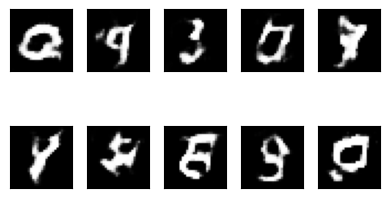

epoch = 72/100, d_loss=-0.074, g_loss=-0.064                                                                                                                      
epoch = 73/100, d_loss=-0.090, g_loss=-0.058                                                                                                                      
epoch = 74/100, d_loss=-0.103, g_loss=-0.065                                                                                                                      
epoch = 75/100, d_loss=-0.103, g_loss=-0.071                                                                                                                      
epoch = 76/100, d_loss=-0.110, g_loss=-0.040                                                                                                                      
epoch = 77/100, d_loss=-0.094, g_loss=-0.064                                                                                                                      
epoch = 78/100, d_loss

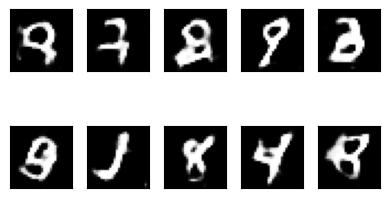

epoch = 82/100, d_loss=-0.045, g_loss=-0.103                                                                                                                      
epoch = 83/100, d_loss=-0.042, g_loss=-0.105                                                                                                                      
epoch = 84/100, d_loss=-0.053, g_loss=-0.096                                                                                                                      
epoch = 85/100, d_loss=-0.043, g_loss=-0.087                                                                                                                      
epoch = 86/100, d_loss=-0.052, g_loss=-0.096                                                                                                                      
epoch = 87/100, d_loss=-0.025, g_loss=-0.072                                                                                                                      
epoch = 88/100, d_loss

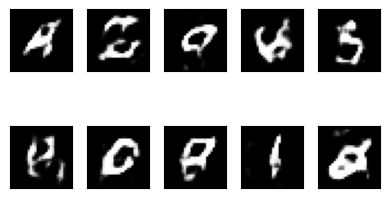

epoch = 92/100, d_loss=-0.027, g_loss=-0.001                                                                                                                      
epoch = 93/100, d_loss=-0.029, g_loss=-0.011                                                                                                                      
epoch = 94/100, d_loss=-0.024, g_loss=-0.015                                                                                                                      
epoch = 95/100, d_loss=-0.021, g_loss=-0.030                                                                                                                      
epoch = 96/100, d_loss=-0.013, g_loss=-0.026                                                                                                                      
epoch = 97/100, d_loss=-0.016, g_loss=-0.019                                                                                                                      
epoch = 98/100, d_loss

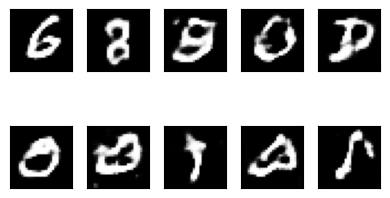

In [13]:
epochs = 100
batch_size = 64

real = -tf.ones(shape=(batch_size, 1))
fake = tf.ones(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            X_batch = X_train[i * batch_size : (i + 1) * batch_size]
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = tf.random.normal(
                shape=(batch_size, latent_dim), mean=0, stddev=1
            )
            X_fake = generator.predict_on_batch(z)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Clip critic weights
            for l in critic.layers:
                weights = l.get_weights()
                weights = [
                    np.clip(w, -clip_value, clip_value) for w in weights
                ]
                l.set_weights(weights)

        # Train Generator weights
        critic.trainable = False
        g_loss_batch = c_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict_on_batch(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap="gray")
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

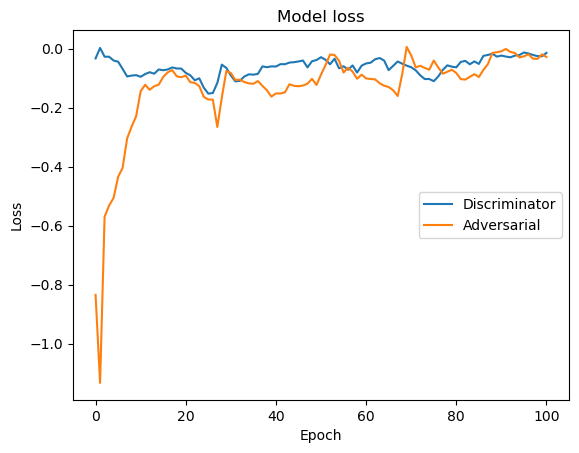

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()


## References

* [GAN — Wasserstein GAN & WGAN-GP](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)